In [49]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.distributions as dist
from torch.nn import Parameter
import sys
sys.path.append('../')
import probtorch
from probtorch.util import expand_inputs
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+f9f5c9b torch: 0.4.1 cuda: True


## ProbTorch

* Probtorch is an extension of Pytroch for deep generative models
* Intended to be like Pytorch as much as possible
* Models in ProbTorch are written just like in PyTorch but with three additional constructs
    * A library of reparametrized distributions avaliable in Pytorch
    * A Trace datastructue to instantiate and store random variable
    * Objective function that approximate the lower bound on the log-marginal likelihood

### Drawing sample from unit Normal 

In [60]:
loc = 0.   # mean zero
scale = 1. # unit variance

In [61]:
q = probtorch.Trace()
x = q.normal(loc = loc, scale = scale, name = 'my_sample')
print("sample", x)
print(q)

sample tensor(-2.6196)
Trace{'my_sample': Normal([torch.FloatTensor of size ])}


## Simple Model 

Let’s suppose we have a bunch of data with daily mean temperatures and cloud cover. We want to reason about how temperature interacts with whether it was sunny or cloudy. A simple stochastic function that does that is given by:

In [43]:
def weather():
    q = probtorch.Trace()
    cloudy = q.relaxed_bernoulli(0,0.3, name = 'cloudy')
    cloudy = 'cloudy' if cloudy == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = q.normal(loc = mean_temp, scale = scale_temp, name = 'temp')
    return cloudy, temp

for _ in range(3):
    print(weather())


('cloudy', tensor(48.4629))
('cloudy', tensor(70.0119))
('cloudy', tensor(68.4070))


In [28]:
def ice_cream_sales():
    q = probtorch.Trace()
    cloudy, temp = weather()
    expected_sales = 200. if cloudy == 'sunny' and temp > 80.0 else 50.
#     ice_cream = pyro.sample('ice_cream', dist.Normal(expected_sales, 10.0))
    ice_cream = q.normal(loc = expected_sales, scale = 10.0)
    return ice_cream

In [29]:
ice_cream_sales()

tensor(34.9885)

## Stochastic Recursion, Higher-order Stochastic Functions, and Random Control Flow 

* We saw that Pyro can handle non-determistic termination in recusion and random control flow

In [45]:
def geometric(p, q, t=None):
    
    if t is None:
        t = 0
        
#     x = pyro.sample("x_{}".format(t), dist.Bernoulli(p))
    x = q.relaxed_bernoulli(0,p, name = 'x_{}'.format(t))
    if x.item() == 1:
        return 0
    else:
        return 1 + geometric(p, q, t + 1)

q = probtorch.Trace()
print(geometric(0.1, q))
print(q)

7
Trace{'x_0': RelaxedBernoulli([torch.FloatTensor of size ]), 'x_1': RelaxedBernoulli([torch.FloatTensor of size ]), 'x_2': RelaxedBernoulli([torch.FloatTensor of size ]), 'x_3': RelaxedBernoulli([torch.FloatTensor of size ]), 'x_4': RelaxedBernoulli([torch.FloatTensor of size ]), 'x_5': RelaxedBernoulli([torch.FloatTensor of size ]), 'x_6': RelaxedBernoulli([torch.FloatTensor of size ]), 'x_7': RelaxedBernoulli([torch.FloatTensor of size ])}


* Stochastic functions that accept as input or produce as output other stochastic functions:

In [37]:
def normal_product(q, loc, scale):
#     z1 = pyro.sample("z1", dist.Normal(loc, scale))
    z1 = q.normal(loc, scale)
#     z2 = pyro.sample("z2", dist.Normal(loc, scale))
    z2 = q.normal(loc, scale)
    y = z1 * z2
    return y

def make_normal_normal(q):
#     mu_latent = pyro.sample("mu_latent", dist.Normal(0, 1))
    mu_latent = q.normal(loc = 0, scale = 1)
    fn = lambda scale: normal_product(q,mu_latent, scale)
    return fn

q = probtorch.Trace()
print(make_normal_normal(q)(3.))
print(q)

tensor(-1.3099)
Trace{'normal_0': Normal([torch.FloatTensor of size ]), 'normal_1': Normal([torch.FloatTensor of size ]), 'normal_2': Normal([torch.FloatTensor of size ])}


# Conditioning on Data (Observe)

* Given observed data we want to infer the latent factors that could have generated it

In [66]:
q = probtorch.Trace()
x = q.normal(loc = loc, scale = scale, value = .01, name = 'obs')

# Mini-Example 

In [87]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.nn import Parameter
import sys
sys.path.append('../')
import probtorch
from probtorch.util import expand_inputs
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+f9f5c9b torch: 0.4.1 cuda: True


In [88]:
# model parameters
NUM_PIXELS = 784
NUM_HIDDEN = 256
NUM_DIGITS = 10
NUM_STYLE = 50   

# training parameters
NUM_SAMPLES = 8 
NUM_BATCH = 128
NUM_EPOCHS = 200
LABEL_FRACTION = 0.1
LEARNING_RATE = 1e-3
BETA1 = 0.90
EPS = 1e-9
#CUDA = torch.cuda.is_available()
CUDA = True

# path parameters
MODEL_NAME = 'mnist-semisupervised-%02ddim' % NUM_STYLE
DATA_PATH = '../data'
WEIGHTS_PATH = '../weights'
RESTORE = False

In [89]:
class Encoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, 
                       num_hidden=NUM_HIDDEN,
                       num_digits=NUM_DIGITS,
                       num_style=NUM_STYLE,
                       num_batch=NUM_BATCH):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential( 
                            nn.Linear(num_pixels, num_hidden),
                            nn.ReLU())
        self.digit_log_weights = nn.Linear(num_hidden, num_digits)
        self.digit_temp = torch.tensor(0.66)
        self.style_mean = nn.Linear(num_hidden + num_digits, num_style)
        self.style_log_std = nn.Linear(num_hidden + num_digits, num_style)
    
    @expand_inputs
    def forward(self, images, labels=None, num_samples=None):
        q = probtorch.Trace()
        hiddens = self.enc_hidden(images)
        digits = q.concrete(logits=self.digit_log_weights(hiddens),
                            temperature=self.digit_temp,
                            value=labels,
                            name='digits')
        hiddens2 = torch.cat([digits, hiddens], -1)
        styles_mean = self.style_mean(hiddens2)
        styles_std = torch.exp(self.style_log_std(hiddens2))
        q.normal(styles_mean,
                 styles_std,
                 name='styles')
        return q

In [90]:

class Decoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, 
                       num_hidden=NUM_HIDDEN,
                       num_digits=NUM_DIGITS,
                       num_style=NUM_STYLE):
        super(self.__class__, self).__init__()
        self.num_digits = num_digits
        self.digit_log_weights = torch.zeros(num_digits)
        self.digit_temp = 0.66
        self.style_mean = torch.zeros(num_style)
        self.style_std = torch.ones(num_style)
        self.dec_hidden = nn.Sequential(
                            nn.Linear(num_style + num_digits, num_hidden),
                            nn.ReLU())
        self.dec_image = nn.Sequential(
                           nn.Linear(num_hidden, num_pixels),
                           nn.Sigmoid())

    def forward(self, images, q=None, num_samples=None):
        p = probtorch.Trace()
        digits = p.concrete(logits=self.digit_log_weights,
                            temperature=self.digit_temp,
                            value=q['digits'],
                            name='digits')
        styles = p.normal(self.style_mean, 
                          self.style_std,
                          value=q['styles'],
                          name='styles')
        hiddens = self.dec_hidden(torch.cat([digits, styles], -1))
        images_mean = self.dec_image(hiddens)
        p.loss(lambda x_hat, x: -(torch.log(x_hat + EPS) * x + 
                                  torch.log(1 - x_hat + EPS) * (1-x)).sum(-1),
               images_mean, images, name='images')
        return p

In [91]:
def elbo(q, p, alpha=0.1):
    if NUM_SAMPLES is None:
        return probtorch.objectives.montecarlo.elbo(q, p, sample_dim=None, batch_dim=0, alpha=alpha)
    else:
        return probtorch.objectives.montecarlo.elbo(q, p, sample_dim=0, batch_dim=1, alpha=alpha)

In [92]:
from torchvision import datasets, transforms
import os 

if not os.path.isdir(DATA_PATH):
    os.makedirs(DATA_PATH)

train_data = torch.utils.data.DataLoader(
                datasets.MNIST(DATA_PATH, train=True, download=True,
                               transform=transforms.ToTensor()),
                batch_size=NUM_BATCH, shuffle=True) 
test_data = torch.utils.data.DataLoader(
                datasets.MNIST(DATA_PATH, train=False, download=True,
                               transform=transforms.ToTensor()),
                batch_size=NUM_BATCH, shuffle=True)

Processing...
Done!


In [93]:

def cuda_tensors(obj): 
    for attr in dir(obj):
        value = getattr(obj, attr)
        if isinstance(value, torch.Tensor):
            setattr(obj, attr, value.cuda())

enc = Encoder()
dec = Decoder()
if CUDA:
    enc.cuda()
    dec.cuda()
    cuda_tensors(enc)
    cuda_tensors(dec)

optimizer =  torch.optim.Adam(list(enc.parameters())+list(dec.parameters()),
                              lr=LEARNING_RATE,
                              betas=(BETA1, 0.999))

In [94]:

def train(data, enc, dec, optimizer, 
          label_mask={}, label_fraction=LABEL_FRACTION):
    epoch_elbo = 0.0
    enc.train()
    dec.train()
    N = 0
    for b, (images, labels) in enumerate(data):
        if images.size()[0] == NUM_BATCH:
            N += NUM_BATCH
            images = images.view(-1, NUM_PIXELS)
            labels_onehot = torch.zeros(NUM_BATCH, NUM_DIGITS)
            labels_onehot.scatter_(1, labels.unsqueeze(1), 1)
            labels_onehot = torch.clamp(labels_onehot, EPS, 1-EPS)
            if CUDA:
                images = images.cuda()
                labels_onehot = labels_onehot.cuda()
            optimizer.zero_grad()
            if b not in label_mask:
                label_mask[b] = (random() < label_fraction)
            if label_mask[b]:
                q = enc(images, labels_onehot, num_samples=NUM_SAMPLES)
            else:
                q = enc(images, num_samples=NUM_SAMPLES)
            p = dec(images, q, num_samples=NUM_SAMPLES)
            loss = -elbo(q, p)
            loss.backward()
            optimizer.step()
            if CUDA:
                loss = loss.cpu()
            epoch_elbo -= loss.item()
    return epoch_elbo / N, label_mask

def test(data, enc, dec, infer=True):
    enc.eval()
    dec.eval()
    epoch_elbo = 0.0
    epoch_correct = 0
    N = 0
    for b, (images, labels) in enumerate(data):
        if images.size()[0] == NUM_BATCH:
            N += NUM_BATCH
            images = images.view(-1, NUM_PIXELS)
            if CUDA:
                images = images.cuda()
            q = enc(images, num_samples=NUM_SAMPLES)
            p = dec(images, q, num_samples=NUM_SAMPLES)
            batch_elbo = elbo(q, p)
            if CUDA:
                batch_elbo = batch_elbo.cpu()
            epoch_elbo += batch_elbo.item()
            if infer:
                log_p = p.log_joint(0, 1)
                log_q = q.log_joint(0, 1)
                log_w = log_p - log_q
                w = torch.nn.functional.softmax(log_w, 0)
                y_samples = q['digits'].value
                y_expect = (w.unsqueeze(-1) * y_samples).sum(0)
                _ , y_pred = y_expect.max(-1)
                if CUDA:
                    y_pred = y_pred.cpu()
                epoch_correct += (labels == y_pred).sum().item()
            else:
                _, y_pred = q['digits'].value.max(-1)
                if CUDA:
                    y_pred = y_pred.cpu()
                epoch_correct += (labels == y_pred).sum().item() / (NUM_SAMPLES or 1.0)
    return epoch_elbo / N, epoch_correct / N

In [96]:
import time
from random import random
if not RESTORE:
    mask = {}
    for e in range(NUM_EPOCHS):
        train_start = time.time()
        train_elbo, mask = train(train_data, enc, dec, 
                                 optimizer, mask, LABEL_FRACTION)
        train_end = time.time()
        test_start = time.time()
        test_elbo, test_accuracy = test(test_data, enc, dec)
        test_end = time.time()
        print('[Epoch %d] Train: ELBO %.4e (%ds) Test: ELBO %.4e, Accuracy %0.3f (%ds)' % (
                e, train_elbo, train_end - train_start, 
                test_elbo, test_accuracy, test_end - test_start))

    if not os.path.isdir(WEIGHTS_PATH):
        os.mkdir(WEIGHTS_PATH)
    torch.save(enc.state_dict(),
               '%s/%s-%s-%s-enc.rar' % (WEIGHTS_PATH, MODEL_NAME, probtorch.__version__, torch.__version__))
    torch.save(dec.state_dict(),
               '%s/%s-%s-%s-dec.rar' % (WEIGHTS_PATH, MODEL_NAME, probtorch.__version__, torch.__version__))
    

[Epoch 0] Train: ELBO -1.3997e+00 (4s) Test: ELBO -1.0892e+00, Accuracy 0.180 (0s)
[Epoch 1] Train: ELBO -1.0176e+00 (4s) Test: ELBO -9.4982e-01, Accuracy 0.260 (0s)
[Epoch 2] Train: ELBO -9.3004e-01 (4s) Test: ELBO -8.9700e-01, Accuracy 0.379 (0s)
[Epoch 3] Train: ELBO -8.9005e-01 (4s) Test: ELBO -8.6820e-01, Accuracy 0.484 (0s)
[Epoch 4] Train: ELBO -8.6746e-01 (4s) Test: ELBO -8.5141e-01, Accuracy 0.572 (0s)
[Epoch 5] Train: ELBO -8.5330e-01 (4s) Test: ELBO -8.4067e-01, Accuracy 0.637 (0s)
[Epoch 6] Train: ELBO -8.4359e-01 (4s) Test: ELBO -8.3348e-01, Accuracy 0.669 (0s)
[Epoch 7] Train: ELBO -8.3619e-01 (4s) Test: ELBO -8.2719e-01, Accuracy 0.701 (0s)
[Epoch 8] Train: ELBO -8.3030e-01 (4s) Test: ELBO -8.2169e-01, Accuracy 0.725 (0s)
[Epoch 9] Train: ELBO -8.2569e-01 (4s) Test: ELBO -8.1752e-01, Accuracy 0.752 (0s)
[Epoch 10] Train: ELBO -8.2155e-01 (4s) Test: ELBO -8.1475e-01, Accuracy 0.770 (0s)
[Epoch 11] Train: ELBO -8.1822e-01 (4s) Test: ELBO -8.1162e-01, Accuracy 0.780 (0s)
[E

[Epoch 98] Train: ELBO -7.7352e-01 (4s) Test: ELBO -7.7474e-01, Accuracy 0.931 (0s)
[Epoch 99] Train: ELBO -7.7341e-01 (4s) Test: ELBO -7.7436e-01, Accuracy 0.932 (0s)
[Epoch 100] Train: ELBO -7.7330e-01 (4s) Test: ELBO -7.7430e-01, Accuracy 0.933 (0s)
[Epoch 101] Train: ELBO -7.7324e-01 (4s) Test: ELBO -7.7442e-01, Accuracy 0.934 (0s)
[Epoch 102] Train: ELBO -7.7310e-01 (4s) Test: ELBO -7.7349e-01, Accuracy 0.933 (0s)
[Epoch 103] Train: ELBO -7.7286e-01 (4s) Test: ELBO -7.7386e-01, Accuracy 0.934 (0s)
[Epoch 104] Train: ELBO -7.7291e-01 (4s) Test: ELBO -7.7361e-01, Accuracy 0.933 (0s)
[Epoch 105] Train: ELBO -7.7266e-01 (4s) Test: ELBO -7.7414e-01, Accuracy 0.937 (0s)
[Epoch 106] Train: ELBO -7.7253e-01 (4s) Test: ELBO -7.7375e-01, Accuracy 0.933 (0s)
[Epoch 107] Train: ELBO -7.7259e-01 (4s) Test: ELBO -7.7371e-01, Accuracy 0.935 (0s)
[Epoch 108] Train: ELBO -7.7247e-01 (4s) Test: ELBO -7.7303e-01, Accuracy 0.934 (0s)
[Epoch 109] Train: ELBO -7.7231e-01 (4s) Test: ELBO -7.7366e-01, Ac

[Epoch 195] Train: ELBO -7.6615e-01 (4s) Test: ELBO -7.6928e-01, Accuracy 0.949 (0s)
[Epoch 196] Train: ELBO -7.6604e-01 (4s) Test: ELBO -7.6981e-01, Accuracy 0.950 (0s)
[Epoch 197] Train: ELBO -7.6607e-01 (4s) Test: ELBO -7.6992e-01, Accuracy 0.948 (0s)
[Epoch 198] Train: ELBO -7.6603e-01 (4s) Test: ELBO -7.6961e-01, Accuracy 0.950 (0s)
[Epoch 199] Train: ELBO -7.6591e-01 (4s) Test: ELBO -7.6912e-01, Accuracy 0.948 (0s)


In [97]:
if RESTORE:
    enc.load_state_dict(torch.load('%s/%s-%s-%s-enc.rar' % (WEIGHTS_PATH, MODEL_NAME, probtorch.__version__, torch.__version__)))
    dec.load_state_dict(torch.load('%s/%s-%s-%s-dec.rar' % (WEIGHTS_PATH, MODEL_NAME, probtorch.__version__, torch.__version__)))

In [98]:
print('[encoder] ELBO: %e, ACCURACY: %f' % test(test_data, enc, dec, infer=False))
print('[encoder+inference] ELBO: %e, ACCURACY: %f' % test(test_data, enc, dec, infer=True))

[encoder] ELBO: -7.690688e-01, ACCURACY: 0.941732
[encoder+inference] ELBO: -7.691405e-01, ACCURACY: 0.949619


In [99]:

import numpy as np
ys = []
zs = []
for (x, y) in test_data:
    if len(x) == NUM_BATCH:
        images = x.view(-1, NUM_PIXELS)
        if CUDA:
            q = enc(images.cuda())
            z = q['styles'].value.cpu().detach().numpy()
        else:
            q = enc(images)
            z = q['styles'].value.data.detach().numpy()
        zs.append(z)
        ys.append(y.numpy())
ys = np.concatenate(ys,0)
zs = np.concatenate(zs,0)

In [100]:
# run TSNE when number of latent dims exceeds 2
if NUM_STYLE > 2:
    from sklearn.manifold import TSNE
    zs2 = TSNE().fit_transform(zs)
    zs2_mean = zs2.mean(0)
    zs2_std = zs2.std(0)
else:
    zs2 = zs

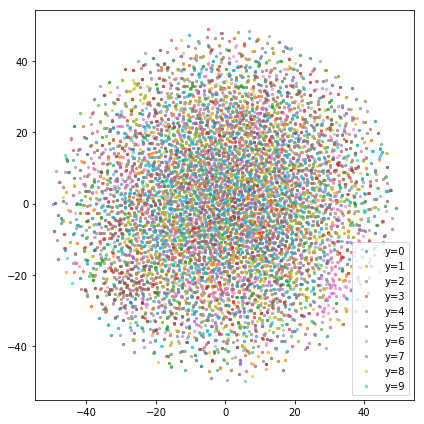

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline

# display a 2D plot of the digit classes in the latent space
fig = plt.figure(figsize=(6,6))
ax = plt.gca()

colors = []
for k in range(10):
    m = (ys == k)
    p = ax.scatter(zs2[m, 0], zs2[m, 1], label='y=%d' % k, alpha=0.5, s=5)
    colors.append(p.get_facecolor())
ax.legend()

fig.tight_layout()
#fig.savefig('images/%s-%02d-encodings.png' % (MODEL_NAME, NUM_STYLE), dpi=300)

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

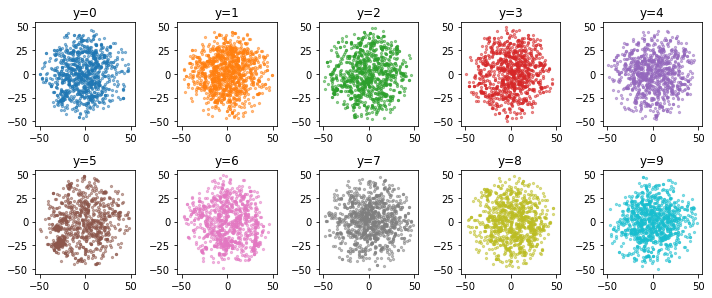

In [102]:
# display a 2D plot of the digit classes in the latent space
fig = plt.figure(figsize=(10,4.25))

for k in range(10):
    ax = plt.subplot(2,5,k+1)
    m = (ys == k)
    ax.scatter(zs2[m, 0], zs2[m, 1], alpha=0.5, s=5, c=colors[k])
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_title('y=%d' % k)

fig.tight_layout()